In [ ]:
!pip install zeyrek

In [ ]:
import pandas as pd
import nltk
import re
from bs4 import BeautifulSoup
import zeyrek
import matplotlib.pyplot as plt

from nltk.corpus import stopwords #stopwords listesini getirir
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download("stopwords") #stopwords listesini indir
nltk.download("punkt_tab") #tokenizer için gerekli, model dosyalarını indir

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
df = pd.read_csv("hepsiburada_yorumlar.csv", delimiter=";") #veri setini yükleme
df.info()
df.head(9)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   yorum   499 non-null    object
dtypes: object(1)
memory usage: 4.0+ KB


,yorum
0,Kendi kullandigim ile siparis ettigim ayni num...
1,loreal satıcısından aldım paketleme özenliydi ...
2,Üstte görünmesi için 5 yıldız verdim. Ürün ban...
3,Esmer tenliyim ve gözaltlarımı bir ton acsın i...
4,öncelikle ürün güzel bir sekilde kargolanmıştı...
5,Artı yanları: \n-Kapatıcılığı gayet güzel ve t...
6,Favorim bir kapatıcı. Loreal kampanyaları ve i...
7,"Ürünün rengi doğru geldi teşekkür ederim, ayrı..."
8,mükemmel bi paketleme mukemmel ürünler ben 01 ...


In [ ]:
# MorphAnalyzer nesnesini sadece bir kez başlatıyoruz.
analyzer = zeyrek.MorphAnalyzer()

In [ ]:
# Veri temizleme ve Önişleme
def temiz_yorum(text):
  text=BeautifulSoup(text,"html.parser").get_text() #html etiketlerini temizler
  text=text.lower() #büyük küçük harf çevirme
  text = re.sub(r"http\S+", "",text,flags=re.MULTILINE) # URL'leri kalırmak için yapılacak işlemler
  text=re.sub(r"\d+", "",text) #rakamları temizleme
  text=re.sub(r"[^\w\s]", "", text) #özel karakterlerin kaldırılması
  stop_words = set(stopwords.words("turkish"))

  tokens = nltk.word_tokenize(text) #Tokenize et (kelimelere ayır)

  tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
# Lemmatizasyon
  lemmatized = []
  for t in tokens:
      analysis = analyzer.analyze(t)
      if analysis and analysis[0]:
            # Zeyrek analyze metodunda ilk tahminin (analysis[0]) lemma özelliğini alıyoruz
            # Eğer lemma bulunamazsa (Unk), kelimenin kendisini (word) alıyoruz
          parse_result = analysis[0][0] # Parse nesnesine erişim

            # Nesne üzerinden lemma çekme işlemi
          try:
              lemma = parse_result.lemma.lower()
              if lemma == 'unk': # Zeyrek bilinmeyen kelimelere 'Unk' der
                  lemma = t
          except:
              lemma = t
          lemmatized.append(lemma)
      else:
          lemmatized.append(t)

  return " ".join(lemmatized)
df["temiz_yorum"] = df["yorum"].apply(temiz_yorum)

Görüntülenen çıkış son 5000 satıra kısaltıldı.


In [ ]:
df.head(7)

,yorum,temiz_yorum
0,Kendi kullandigim ile siparis ettigim ayni num...,kendi kullandigim siparis ettigim ayni numaral...
1,loreal satıcısından aldım paketleme özenliydi ...,loreal satıcı almak paketlemek özen numara alm...
2,Üstte görünmesi için 5 yıldız verdim. Ürün ban...,üst görünmek yıldız vermek ürün bandrol gönder...
3,Esmer tenliyim ve gözaltlarımı bir ton acsın i...,esmer ten gözaltlarımı bir ton ac istemek ton ...
4,öncelikle ürün güzel bir sekilde kargolanmıştı...,öncelikle ürün güzel bir sekil kargo kargo hız...
5,Artı yanları: \n-Kapatıcılığı gayet güzel ve t...,artı yan kapatmak gayet güzel transparan pudra...
6,Favorim bir kapatıcı. Loreal kampanyaları ve i...,favori bir kapatmak loreal kampanya indirim ku...


In [ ]:
# Metin Temsili: TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2),min_df=5)
X = vectorizer.fit_transform(df["temiz_yorum"])

#kelime kümesi
feature_names = vectorizer.get_feature_names_out()
print(f"TF-IDF Matris Boyut: {X.shape}")


#tdfid skoları içeren bir df oluştur
tfidf_score = X.mean(axis=0).A1 #her kelimenin ortlama tf_idf değerleri
df_tfidf= pd.DataFrame({"word":feature_names, "tfidf_score": tfidf_score})

#skorları sırala ve sonuçları inceler
df_tfidf_sorted= df_tfidf.sort_values(by="tfidf_score", ascending=False)
df_tfidf_sorted.head(20)

TF-IDF Matris Boyut: (499, 338)


,word,tfidf_score
322,ürün,0.080821
120,güzel,0.064613
47,bir,0.049860
199,olmak,0.049842
5,almak,0.042686
99,gelmek,0.040818
157,kapatmak,0.040799
174,kullanmak,0.038274
85,etmek,0.037863
216,renk,0.036635


*   1 veya daha fazla puan	score >= 1	POZİTİF
*   -1 veya daha az puan	score <= -1	NEGATİF
*   -0.9 ile 0.9 arası	-1 < score < 1	NÖTR

In [ ]:
# Duygu Analizi – Sözlük Tabanlı Yaklaşım
positive_words = {
    "iyi", "güzel", "başarılı", "beğen", "sev", "memnun", "mutlu",
    "tavsiye", "öneri", "öneririm", "alkış", "aferin", "tebrik",
    "harika", "mükemmel", "süper", "muhteşem", "şahane", "nefis",
    "kapatıyor", "örtüyor", "kamufle", "örtücü", "kapatıcı", "gizliyor",
    "saklıyor", "maskeliyor", "örtbas", "örtbas ediyor", "kamuflaj",
    "doğal", "hafif", "ince", "şeffaf", "transparan", "görünmez",
    "aydınlık", "parlak", "ışıltı", "ışıltılı", "ferah", "taze", "dinç",
    "genç", "dinlenmiş", "sağlıklı", "canlı", "canlandırıcı",
    "nemli", "yumuşak", "pürüzsüz", "kadife", "ipeksi", "krem",
    "akışkan", "yoğun", "kıvamlı", "yayılabilir", "sürülebilir",
    "kolay", "pratik", "rahat", "konforlu",
    "kalıcı", "kalıcılık", "sabit", "uzun", "gün boyu", "tüm gün",
    "dayanıklı", "sağlam", "uyumlu", "uyuyor", "yakışıyor", "oturuyor",
    "alerjik değil", "tahriş etmez", "hassas", "nazik", "yumuşak",
    "ton", "rengi", "uygun", "doğru", "mükemmel", "güzel", "şık",
    "mat", "mattırıyor", "parlaklık", "parlamaz",
    "ucuz", "uygun", "ekonomik", "değer", "karşılıyor", "hak ediyor",
    "verimli", "tasarruflu", "ekonomik",
    "şık", "güzel", "pratik", "hijyenik", "temiz", "kaliteli",
    "dayanıklı", "kullanışlı",
    "yenilik", "innovasyon", "teknoloji", "formül", "içerik", "malzeme"
}

negative_words = {
    "kötü", "berbat", "rezalet", "felaket", "çöp", "zırva", "saçma",
    "başarısız", "pişman", "keşke", "keşke almasaydım", "para israfı",
    "zaman kaybı", "hayal", "hayal kırıklığı", "hayalim", "beklenti",
    "kapatmıyor", "örtmüyor", "gizlemiyor", "saklamıyor", "maskelenmiyor",
    "belli", "görünüyor", "fark ediliyor", "anlaşılıyor", "belli oluyor",
    "yetersiz", "eksik", "az", "hafif", "zayıf",
    "ağır", "kalın", "yoğun", "belirgin", "fazla", "aşırı", "abartılı",
    "yapay", "plastik", "sentetik", "doğal değil", "yapmacık",
    "soluk", "renksiz", "cansız", "ölü", "bitik", "yoruk",
    "kuruyor", "kurutuyor", "nemlendirmiyor", "nem", "nemli değil",
    "kabuk", "kabuklanma", "pullanma", "dökülme", "soyulma",
    "akıyor", "dağılıyor", "yayılıyor", "yayılma", "dağılma",
    "topaklanma", "topak", "küme", "kümelenme", "katman",
    "yağlı", "yağ", "parlak", "parıltı", "ışıldama",
    "turuncu", "gri", "beyaz", "mor", "mavi", "yeşil", "sarı",
    "uyumsuz", "yakışmıyor", "oturmuyor", "garip", "tuhaf", "acayip",
    "farklı", "başka", "değişik", "orjinal değil", "orijinal",
    "alerji", "alerjik", "tahriş", "kaşıntı", "kızarıklık", "kızarık",
    "döküntü", "sivilce", "akne", "gözenek", "tıkanıklık", "tıkıyor",
    "hassas", "hassasiyet", "yanma", "sızlama", "acı", "ağrı",
    "kısa", "az", "yetersiz", "çabuk", "hemen", "kısa sürede",
    "siliniyor", "çıkıyor", "akıyor", "dağılıyor",
    "pahalı", "fazla", "yüksek", "lüks", "elit", "karşılamıyor",
    "değmez", "değmiyor", "hak etmiyor", "hakkı", "haksız",
    "kırık", "hasarlı", "sızıntı", "sızıyor", "kaçak", "kaçırıyor",
    "az", "yetersiz", "küçük", "mini", "bitmiş", "tükenmiş",
    "koku", "kokuyor", "kötü koku", "ağır koku", "küf", "küflü"
}
# anlamı tersine çeviren negasyon ifadeleri
negations = {
    "değil", "yok", "hiç", "asla", "madı", "medi", "maz", "mez",
    "olmuyor", "etmiyor", "edemiyor", "yapmıyor", "yapamıyor",
    "beklemiyordum", "düşünmüyordum", "sanmıyordum", "zannetmiyordum",
    "beklentim", "beklenti", "umduğum", "umut", "ümit"
}
# duygu yoğunlu arttırma
intensifiers = {
    "çok": 2.0, "fazla": 1.8, "aşırı": 2.5, "son derece": 3.0,
    "gerçekten": 1.5, "kesinlikle": 1.7, "müthiş": 2.2, "inanılmaz": 2.3,
    "berbat": -2.5, "rezalet": -2.8, "felaket": -3.0, "korkunç": -2.7,
    "hiç": -1.8, "asla": -2.0, "kesinlikle hayır": -2.5,
    "biraz": 0.7, "az": 0.6, "kısmen": 0.8, "neredeyse": 0.9,
    "tam": 1.2, "tamamen": 1.3, "bütünüyle": 1.3
}


def sentiment_score(text):
    words = text.split()
    score = 0

    for i, word in enumerate(words):
        if word in positive_words:
            puan = 1
            # Yoğunlaştırıcı kontrolü
            if i > 0 and words[i-1] in intensifiers:
                puan *= intensifiers[words[i-1]]
            score += puan

        elif word in negative_words:
            puan = -1
            # Negasyon kontrolü
            if i > 0 and words[i-1] in negations:
                puan = 1  # Tersine çevir

            else:
                # Yoğunlaştırıcı kontrolü
                if i > 0 and words[i-1] in intensifiers:
                    puan *= intensifiers[words[i-1]]

            score += puan

    return score

def sentiment_label(score):
    if score >= 1:
        return "pozitif"
    elif score <= -1:
        return "negatif"
    else:
        return "nötr"

df["sentiment_score"] = df["temiz_yorum"].apply(sentiment_score)
df["sentiment"] = df["sentiment_score"].apply(sentiment_label)

# Sonuçları göster
sozluk_dagilim = df["sentiment"].value_counts()
for duygu, sayi in sozluk_dagilim.items():
    yuzde = (sayi / len(df)) * 100
    print(f"  {duygu.upper()}: {sayi} yorum (%{yuzde:.1f})")

df[["yorum", "sentiment_score", "sentiment"]].tail(15)

  POZITIF: 216 yorum (%43.3)
  NÖTR: 204 yorum (%40.9)
  NEGATIF: 79 yorum (%15.8)


,yorum,sentiment_score,sentiment
484,"goz altlarina dolmayan, rimele yapismayan, inc...",2.0,pozitif
485,Göktürkshoptan aldım . ALMAYIN ! Ürün sürekli...,-2.0,negatif
486,Her zaman kullandigim ürün tavsiye ederim,1.0,pozitif
487,Güzel beğendim uzun süre gidiyor,2.0,pozitif
488,Biraz açik bir renk almişim ama bu kendi hatam...,1.0,pozitif
489,Ürün çok kötü 00 aldım pembe çıktı ama etikett...,-3.0,negatif
490,Günlük çok pratik lekelerime pıt pıt sürüyorum...,2.0,pozitif
491,Ben çok seviyorum şimdi üçüncüyü aldım. Bundan...,1.0,pozitif
492,Çok güzel ve sağlam geldi teşekkür ederim,2.0,pozitif
493,Beş yıldız verdim görünsün diye Ürün orjinal d...,-1.0,negatif


# BERT puanları yorumlama:
# %90-100 → Çok güvenli
# %70-90 → Güvenli  
# %50-70 → Az güvenli
# %50 → Kararsız


In [ ]:
# Duygu Analizi – Türkçe Bert modeli
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline

model = AutoModelForSequenceClassification.from_pretrained("savasy/bert-base-turkish-sentiment-cased")
tokenizer = AutoTokenizer.from_pretrained("savasy/bert-base-turkish-sentiment-cased")
sa= pipeline("sentiment-analysis", tokenizer=tokenizer, model=model)

bert_sonuclar = []
def bert_with_neutral(text, confidence_threshold=0.65):
    """BERT'e güven eşiği ile nötr sınıfı ekler"""
    if len(text) > 512:
        text = text[:512]

    try:
        sonuc = sa(text)[0]

        if sonuc['score'] < confidence_threshold:
            return 'nötr', sonuc['score']
        elif sonuc['label'] == 'positive':
            return 'pozitif', sonuc['score']
        else:
            return 'negatif', sonuc['score']
    except:
        return 'nötr', 0.5

bert_neutral_sonuclar = []
for yorum in df['yorum']:
    duygu, puan = bert_with_neutral(str(yorum))
    bert_neutral_sonuclar.append((duygu, puan))

df['bert_duygu'] = [sonuc[0] for sonuc in bert_neutral_sonuclar]
df['bert_puan'] = [sonuc[1] for sonuc in bert_neutral_sonuclar]

bert_neutral_dagilim = df['bert_duygu'].value_counts()
for duygu in ['pozitif', 'negatif', 'nötr']:
    sayi = bert_neutral_dagilim.get(duygu, 0)
    yuzde = (sayi / len(df)) * 100
    print(f"   {duygu.upper():8} {sayi:4} yorum   %{yuzde:5.1f}")

df[["yorum", "bert_puan", "bert_duygu"]].tail(15)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


   POZITIF   215 yorum   % 43.1
   NEGATIF   254 yorum   % 50.9
   NÖTR       30 yorum   %  6.0


,yorum,bert_puan,bert_duygu
484,"goz altlarina dolmayan, rimele yapismayan, inc...",0.987556,pozitif
485,Göktürkshoptan aldım . ALMAYIN ! Ürün sürekli...,0.999030,negatif
486,Her zaman kullandigim ürün tavsiye ederim,0.996171,pozitif
487,Güzel beğendim uzun süre gidiyor,0.602448,nötr
488,Biraz açik bir renk almişim ama bu kendi hatam...,0.945036,negatif
489,Ürün çok kötü 00 aldım pembe çıktı ama etikett...,0.999342,negatif
490,Günlük çok pratik lekelerime pıt pıt sürüyorum...,0.966279,negatif
491,Ben çok seviyorum şimdi üçüncüyü aldım. Bundan...,0.997784,pozitif
492,Çok güzel ve sağlam geldi teşekkür ederim,0.986628,pozitif
493,Beş yıldız verdim görünsün diye Ürün orjinal d...,0.999525,negatif


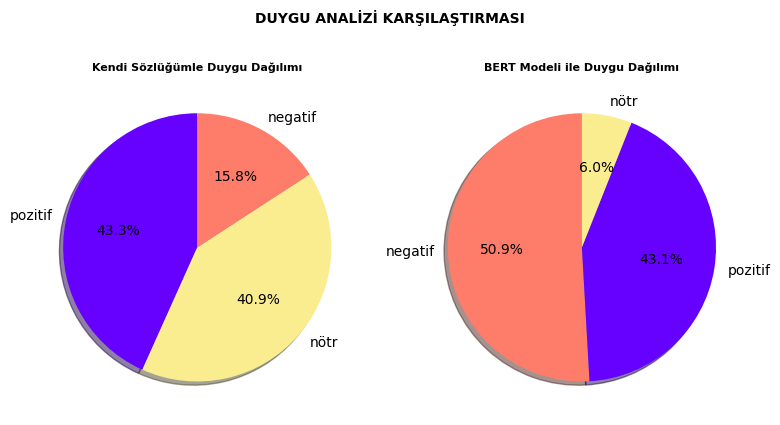

In [ ]:
sozluk_counts = df["sentiment"].value_counts()
bert_counts = df["bert_duygu"].value_counts()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

colors = {'pozitif': '#6600FF', 'negatif': '#FE7D6A', 'nötr': '#Faed8f'}

# Sol: Kendi sözlüğüm
kendi_labels = sozluk_counts.index
kendi_sizes = sozluk_counts.values
kendi_colors = [colors.get(label, '#9E9E9E') for label in kendi_labels]

ax1.pie(kendi_sizes, labels=kendi_labels, autopct='%1.1f%%',
        startangle=90, colors=kendi_colors, shadow=True)
ax1.set_title('Kendi Sözlüğümle Duygu Dağılımı', fontsize=8, fontweight='bold')

# Sağ: BERT modeli
bert_labels = bert_counts.index
bert_sizes = bert_counts.values
bert_colors = [colors.get(label, '#9E9E9E') for label in bert_labels]

ax2.pie(bert_sizes, labels=bert_labels, autopct='%1.1f%%',
        startangle=90, colors=bert_colors, shadow=True)
ax2.set_title('BERT Modeli ile Duygu Dağılımı', fontsize=8, fontweight='bold')

plt.suptitle('DUYGU ANALİZİ KARŞILAŞTIRMASI', fontsize=10, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

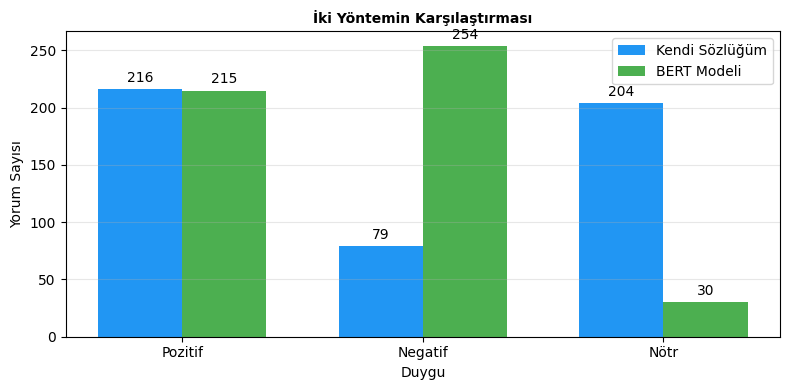

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))

x = range(len(colors))
width = 0.35

kendi_values = [sozluk_counts.get('pozitif', 0),
                sozluk_counts.get('negatif', 0),
                sozluk_counts.get('nötr', 0)]
bert_values = [bert_counts.get('pozitif', 0),
               bert_counts.get('negatif', 0),
               bert_counts.get('nötr', 0)]

rects1 = ax.bar([i - width/2 for i in x], kendi_values, width,
                label='Kendi Sözlüğüm', color='#2196F3')
rects2 = ax.bar([i + width/2 for i in x], bert_values, width,
                label='BERT Modeli', color='#4CAF50')

ax.set_xlabel('Duygu')
ax.set_ylabel('Yorum Sayısı')
ax.set_title('İki Yöntemin Karşılaştırması', fontsize=10, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(['Pozitif', 'Negatif', 'Nötr'])
ax.legend()


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()